# CrabNet predictions

In [1]:
import numpy as np
import pandas as pd
import pickle
import ast
import requests
import re
from matplotlib import pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdFingerprintGenerator
from crabnet.crabnet_ import CrabNet
from crabnet.utils.figures import act_pred
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data preparation

In [2]:
df = pd.read_csv('data_RO2/df_ml_ready.csv')
df.head()

,reduced_formulas,etl,htl,bandgap,device_stack,pce,etl_SMILES,htl_SMILES
0,Ag20Bi20CsI60,"['TiO2-c', 'TiO2-mp']",['P3HT'],1.86,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",3.53,"['O=[Ti]=O', 'O=[Ti]=O']",['CCCCCCC1=C(SC(=C1)C)C']
1,Ag20Bi20CsI60,"['TiO2-c', 'TiO2-mp']",['PTB7-th'],1.86,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",3.53,"['O=[Ti]=O', 'O=[Ti]=O']",['CCC(=CF)COC1=CC=C(C=C1)C23CCC(CC2)(CC3)C(=O)...
2,Ag2BiI5,"['TiO2-c', 'TiO2-mp']",['PTAA'],2.22,"['SLG', 'ITO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",2.60,"['O=[Ti]=O', 'O=[Ti]=O']",['CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C']
3,Ag3BiI6,"['TiO2-c', 'TiO2-mp']",['P3HT'],1.80,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",2.32,"['O=[Ti]=O', 'O=[Ti]=O']",['CCCCCCC1=C(SC(=C1)C)C']
4,Ag3BiI6,"['TiO2-c', 'TiO2-mp']",['PTAA'],0.00,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",4.30,"['O=[Ti]=O', 'O=[Ti]=O']",['CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C']


## Label encoding for string variables

In [3]:
# Get the unique values
device_values = df['device_stack'].unique()
etl_values = df['etl'].unique()
htl_values = df['htl'].unique()

# Create a dictionary mapping each value to an integer
device_dict = {value: index for index, value in enumerate(device_values)}
etl_dict = {value: index for index, value in enumerate(etl_values)}
htl_dict = {value: index for index, value in enumerate(htl_values)}

# Replace each value with its corresponding integer
df_encoded = df.copy()
df_encoded['device_stack_encoded'] = df['device_stack'].map(device_dict)
df_encoded['etl_encoded'] = df['etl'].map(etl_dict)
df_encoded['htl_encoded'] = df['htl'].map(htl_dict)

df_encoded.rename(columns={'pce': 'target'}, inplace=True)
df_encoded.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Train Test Split

In [4]:
# randomize the dataframe and split into train_df, val_df and test_df in the ratio of 0.8, 0.1, 0.1
train_df, val_df, test_df = \
              np.split(df_encoded.sample(frac=1, random_state=42), 
                       [int(.8*len(df_encoded)), int(.9*len(df_encoded))])

# CrabNet predictions

## Absorber only


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Generating EDM: 100%|██████████| 4359/4359 [00:00<00:00, 84899.66formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 545/545 [00:00<00:00, 119032.27formulae/s]


loading data with up to 9 elements in the formula
stepping every 180 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 3.99 val mae: 4.01


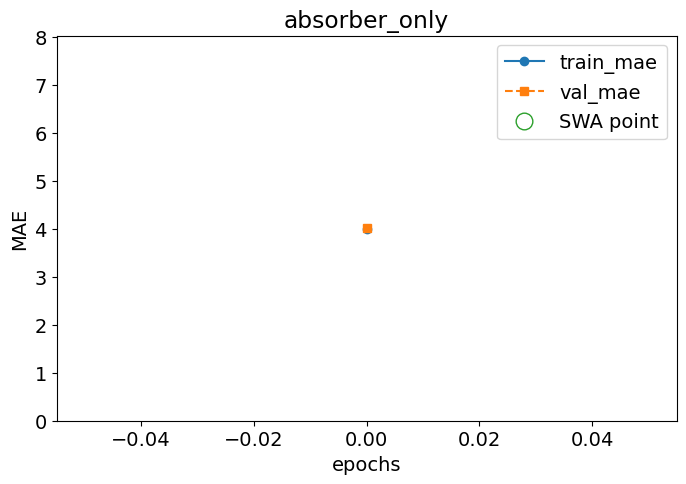

Epoch: 19/300 --- train mae: 2.8 val mae: 3.02


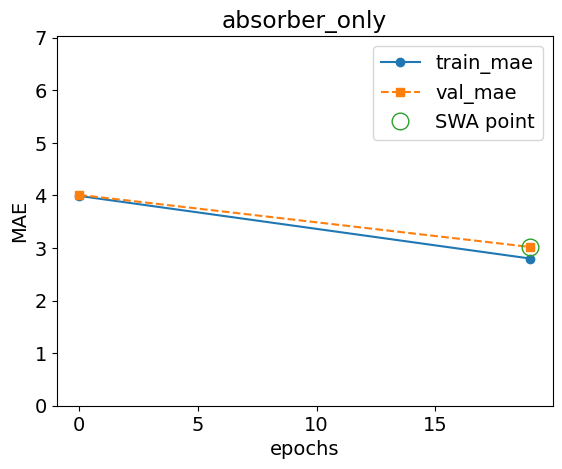

Epoch: 39/300 --- train mae: 2.7 val mae: 3.04


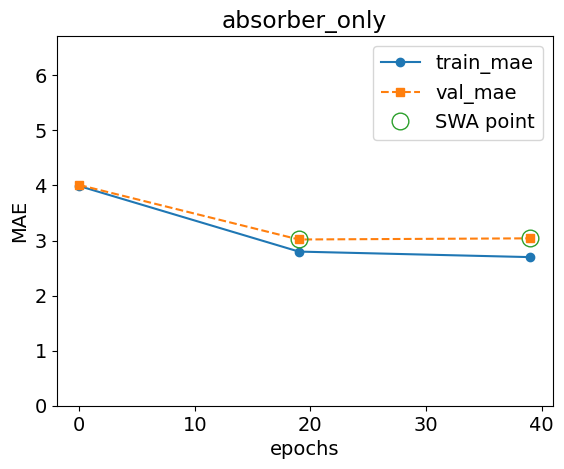

Epoch 59 failed to improve.
Discarded: 1/3 weight updates
Epoch: 59/300 --- train mae: 2.58 val mae: 3.06


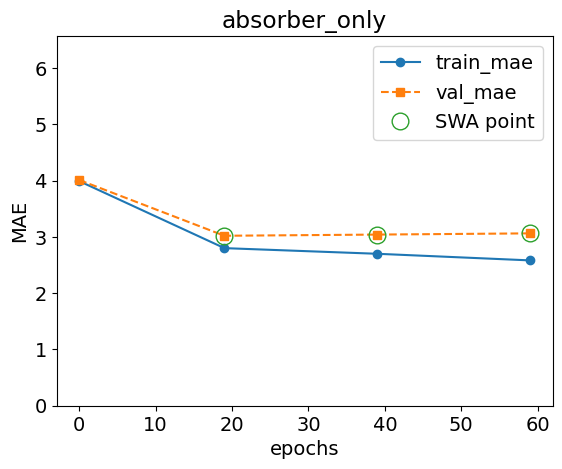

Epoch: 79/300 --- train mae: 2.53 val mae: 3.02


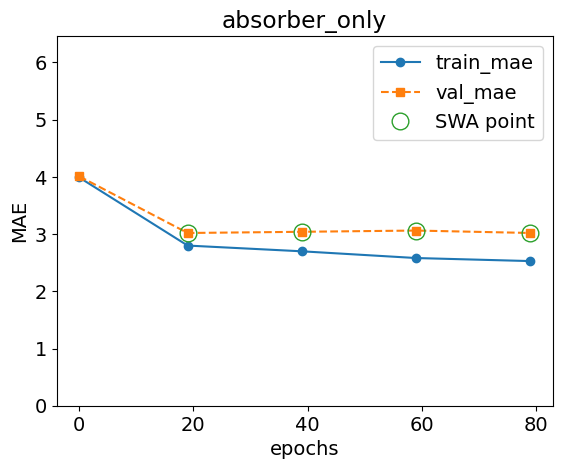

Epoch 99 failed to improve.
Discarded: 2/3 weight updates
Epoch: 99/300 --- train mae: 2.48 val mae: 3.05


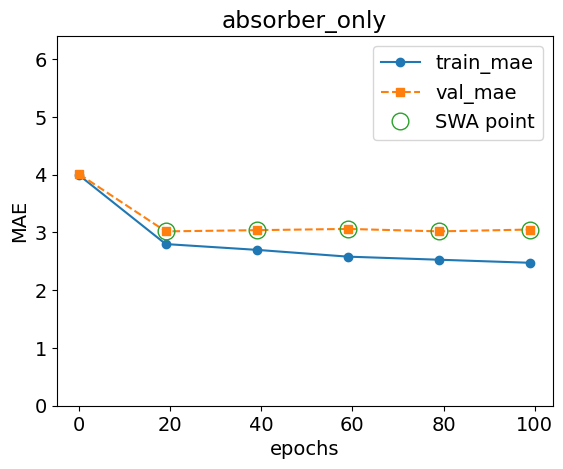

Epoch: 119/300 --- train mae: 2.48 val mae: 3.03


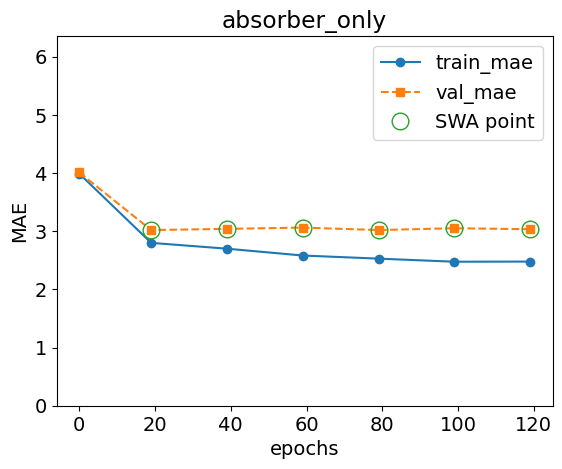

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 2.44 val mae: 3.08


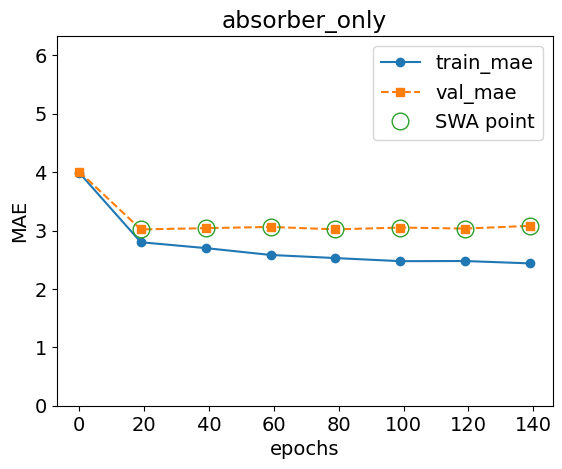

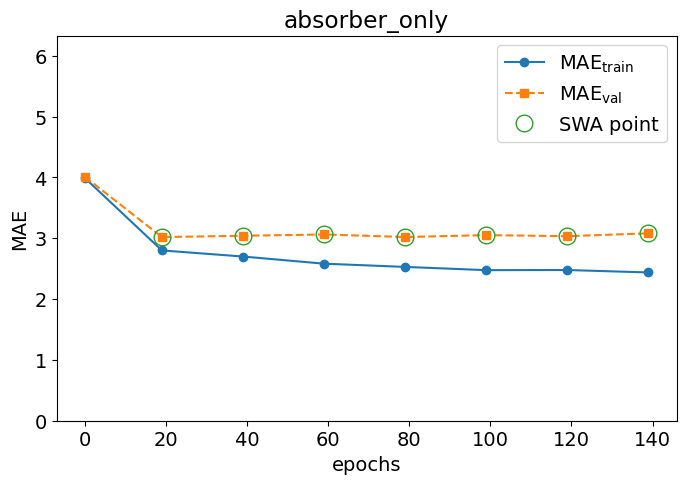

Discarded: 3/3weight updates, early-stopping now
Saving network (absorber_only) to models/trained_models/absorber_only.pth


In [5]:
cb_absorber_only = CrabNet(mat_prop="pce",
                           model_name='absorber_only',
                           elem_prop='mat2vec', 
                           learningcurve=True)
cb_absorber_only.fit(train_df, val_df)

Generating EDM: 100%|██████████| 545/545 [00:00<00:00, 127440.25formulae/s]


loading data with up to 9 elements in the formula


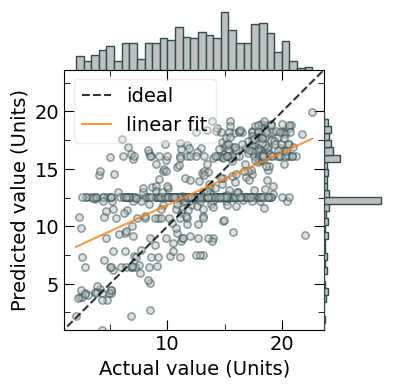

R2 score: 0.396043492803274
MSE: 14.36749377767106
MAE: 2.953780795469787


In [6]:
# Predictions
pred_df = test_df

#pred_df_zeros = pd.DataFrame(({"formula": pred_df['formula'], "target": [0.0]*len(pred_df['formula'])}))
df_predicted, df_predicted_sigma = cb_absorber_only.predict(test_df, return_uncertainty=True)

act_pred(test_df['target'], df_predicted)
r2 = r2_score(test_df['target'], df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(test_df['target'], df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(test_df['target'], df_predicted)
print(f'MAE: {mae}')

## Absorber + label encoded etl, htl and device stack

For some odd reason you cannot execute this after having trained another CrabNet model. Restart the kernel first.

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 4359/4359 [00:00<00:00, 99250.70formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 545/545 [00:00<00:00, 123709.04formulae/s]


loading data with up to 9 elements in the formula
stepping every 180 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 3.99 val mae: 4.01


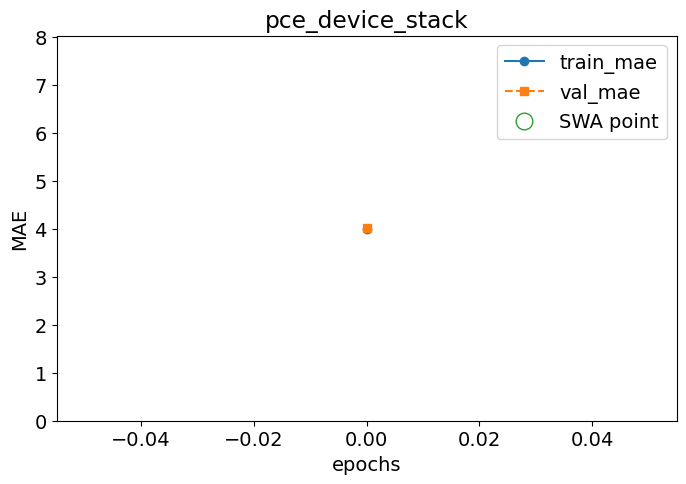

Epoch: 19/300 --- train mae: 2.8 val mae: 3.02


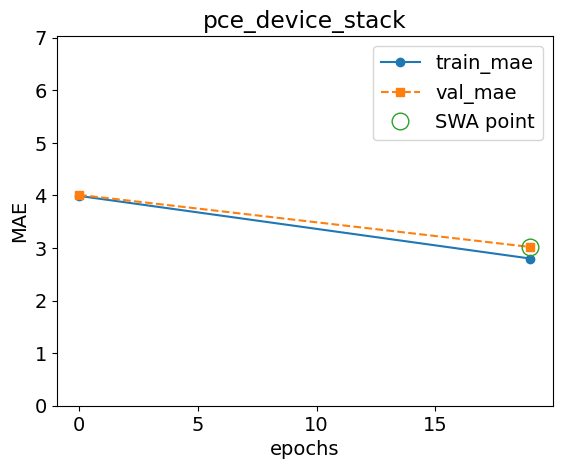

Epoch: 39/300 --- train mae: 2.7 val mae: 3.04


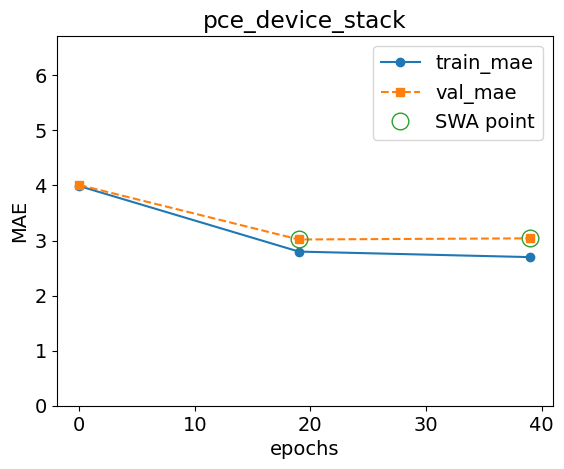

Epoch 59 failed to improve.
Discarded: 1/3 weight updates
Epoch: 59/300 --- train mae: 2.58 val mae: 3.06


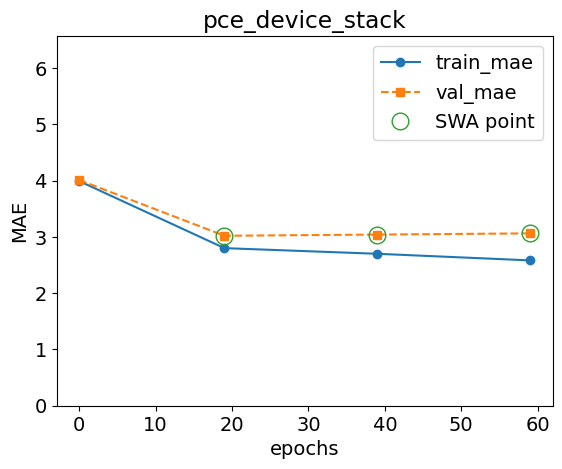

Epoch: 79/300 --- train mae: 2.53 val mae: 3.02


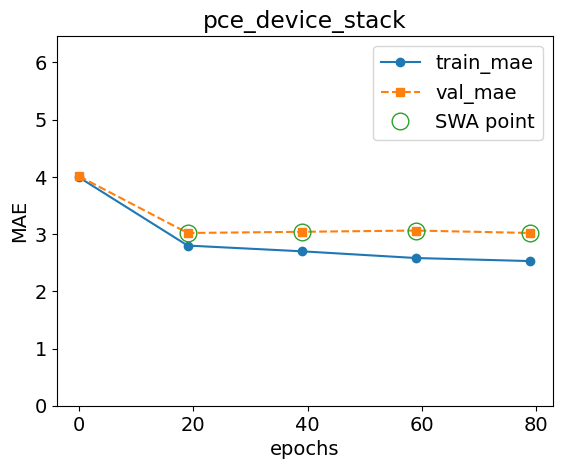

Epoch 99 failed to improve.
Discarded: 2/3 weight updates
Epoch: 99/300 --- train mae: 2.48 val mae: 3.05


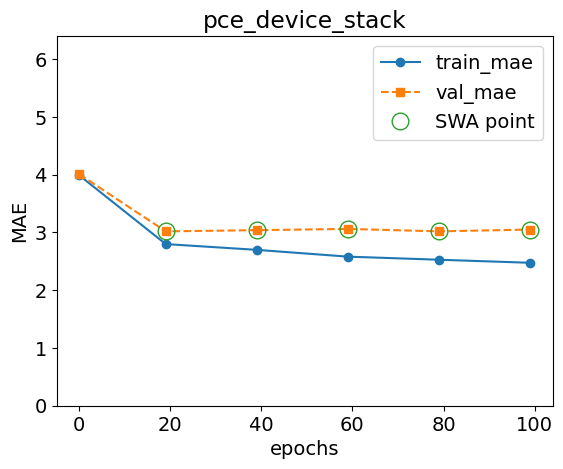

Epoch: 119/300 --- train mae: 2.48 val mae: 3.03


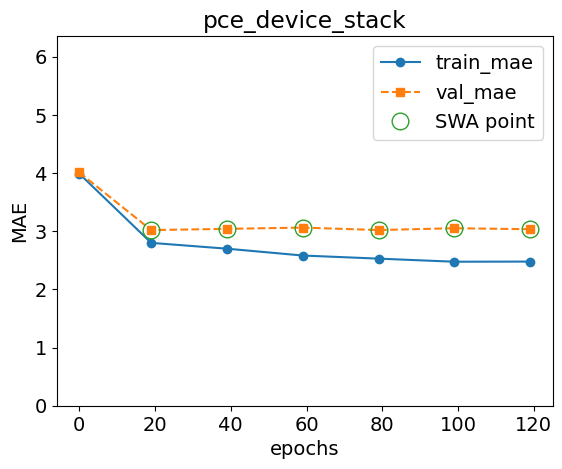

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 2.44 val mae: 3.08


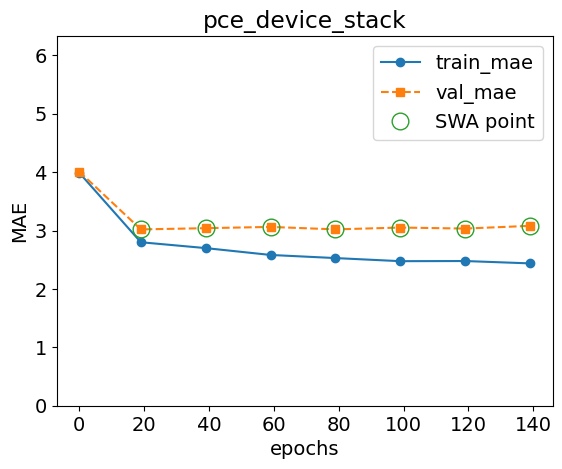

Discarded: 3/3weight updates, early-stopping now
Saving network (pce_device_stack) to models/trained_models/pce_device_stack.pth


In [5]:
cb_labels = CrabNet(mat_prop="pce",
                    model_name='pce_device_stack',
                    elem_prop='mat2vec', 
                    learningcurve=False, 
                    extend_features=['device_stack_encoded', 'etl_encoded', 'htl_encoded'])
cb_labels.fit(train_df, val_df)

Generating EDM: 100%|██████████| 545/545 [00:00<00:00, 134789.53formulae/s]


loading data with up to 9 elements in the formula


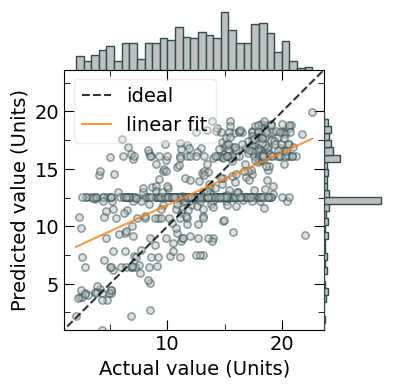

R2 score: 0.396043492803274
MSE: 14.36749377767106
MAE: 2.953780795469787


In [6]:
# Predictions
pred_df = test_df

pred_df_zeros = pd.DataFrame(({"formula": pred_df['formula'],
                               "target": [0.0]*len(pred_df['formula']),
                               "device_stack_encoded": pred_df['device_stack_encoded'],
                               "etl_encoded": pred_df['etl_encoded'],
                               "htl_encoded": pred_df['htl_encoded']}))
df_predicted, df_predicted_sigma = cb_labels.predict(pred_df_zeros, return_uncertainty=True)

act_pred(pred_df['target'], df_predicted)
r2 = r2_score(pred_df['target'], df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(pred_df['target'], df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(pred_df['target'], df_predicted)
print(f'MAE: {mae}')

## Absorber and Fingerprints

### Specific data preparation

In [5]:
etl_combined_SMILES = []
htl_combined_SMILES = []

df['etl_SMILES'] = df['etl_SMILES'].apply(ast.literal_eval)
df['htl_SMILES'] = df['htl_SMILES'].apply(ast.literal_eval)

for index, row in df.iterrows():
    etl_combination = ".".join(row['etl_SMILES'])
    htl_combination = ".".join(row['htl_SMILES'])
    etl_combined_SMILES.append(etl_combination)
    htl_combined_SMILES.append(htl_combination)
df['etl_combined_SMILES'] = etl_combined_SMILES
df['htl_combined_SMILES'] = htl_combined_SMILES

df['etl_combined_SMILES'] = df['etl_combined_SMILES'].str.replace('no_ctl', '')
df['htl_combined_SMILES'] = df['htl_combined_SMILES'].str.replace('no_ctl', '')

fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)

def smiles_to_fingerprint(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return np.zeros(fpgen.GetNumBits(),)
    fp = fpgen.GetFingerprint(molecule)
    # Convert to a bit vector
    bit_vector = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, bit_vector)
    return bit_vector

# Create columns for Morgan Fingerprints
etl_fingerprints = df['etl_combined_SMILES'].apply(smiles_to_fingerprint)
htl_fingerprints = df['htl_combined_SMILES'].apply(smiles_to_fingerprint)

# Convert fingerprints to DataFrame
etl_fingerprint_df = pd.DataFrame(etl_fingerprints.tolist(), columns=[f'ETL_FP_{i}' for i in range(1024)])
htl_fingerprint_df = pd.DataFrame(htl_fingerprints.tolist(), columns=[f'HTL_FP_{i}' for i in range(1024)])

# Combine all features into a single DataFrame
features_df = pd.DataFrame
features_df = pd.concat([df.drop(columns=['etl', 
                                          'htl', 
                                          'etl_SMILES',
                                          'htl_SMILES',
                                          'etl_combined_SMILES',
                                          'htl_combined_SMILES']), etl_fingerprint_df, htl_fingerprint_df], axis=1)

print(len(features_df))
features_df = features_df.dropna()
print(len(features_df))

features_df.rename(columns={'pce': 'target'}, inplace=True)
features_df.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

[23:03:43] WARNING: not removing hydrogen atom without neighbors
[23:04:06] WARNING: not removing hydrogen atom without neighbors
[23:04:07] WARNING: not removing hydrogen atom without neighbors


5449
5449


In [6]:
# randomize the dataframe and split into train_df, val_df and test_df in the ratio of 0.8, 0.1, 0.1
fp_train_df, fp_val_df, fp_test_df = \
              np.split(features_df.sample(frac=1,
                                          random_state=42), 
                       [int(.8*len(features_df)),
                        int(.9*len(features_df))])

### CrabNet Training


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 4359/4359 [00:00<00:00, 116717.45formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 545/545 [00:00<00:00, 55264.26formulae/s]


loading data with up to 9 elements in the formula
stepping every 180 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 3.99 val mae: 4.01


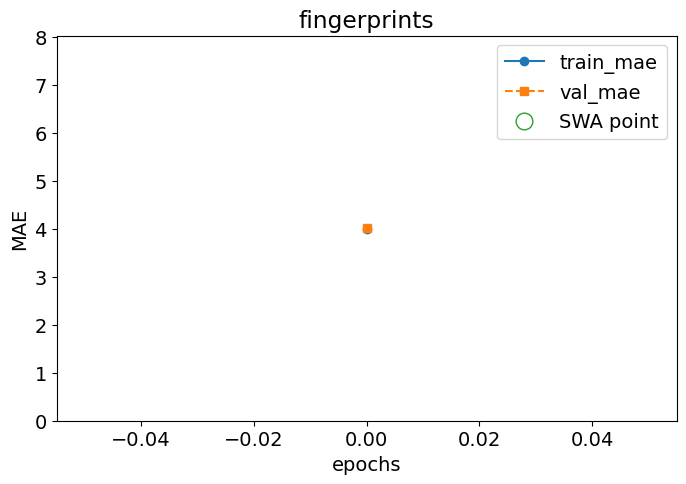

Epoch: 19/300 --- train mae: 2.8 val mae: 3.02


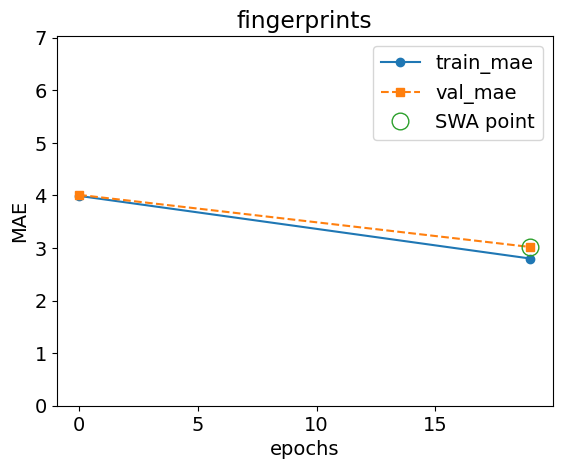

Epoch: 39/300 --- train mae: 2.7 val mae: 3.04


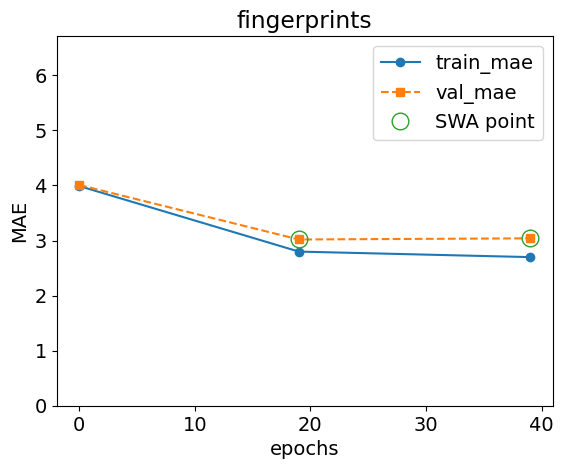

Epoch 59 failed to improve.
Discarded: 1/3 weight updates
Epoch: 59/300 --- train mae: 2.58 val mae: 3.06


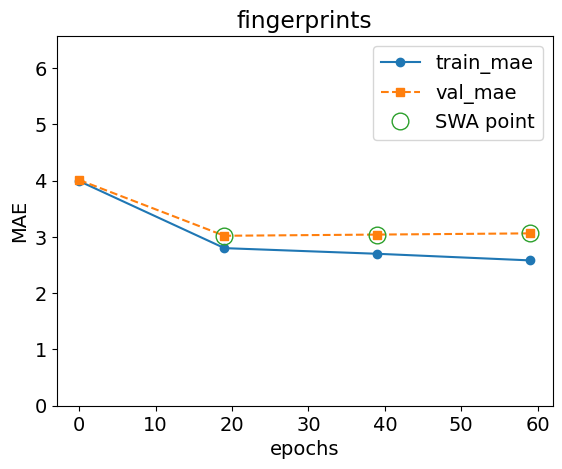

Epoch: 79/300 --- train mae: 2.53 val mae: 3.02


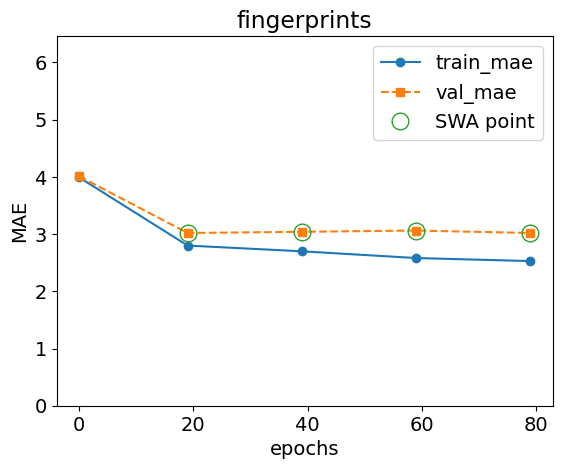

Epoch 99 failed to improve.
Discarded: 2/3 weight updates
Epoch: 99/300 --- train mae: 2.48 val mae: 3.05


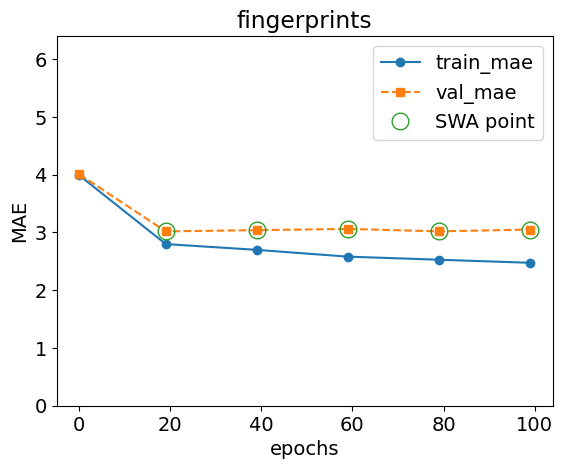

Epoch: 119/300 --- train mae: 2.48 val mae: 3.03


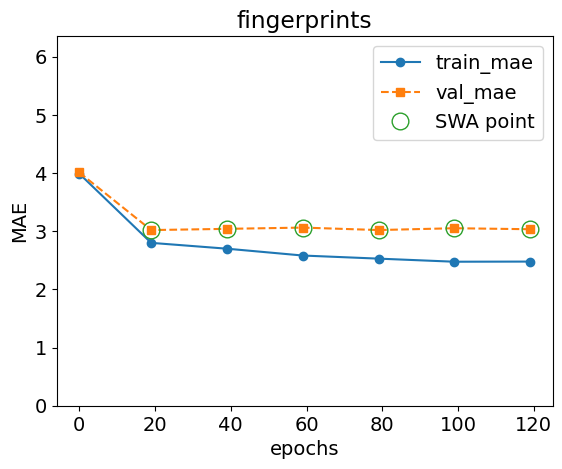

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 2.44 val mae: 3.08


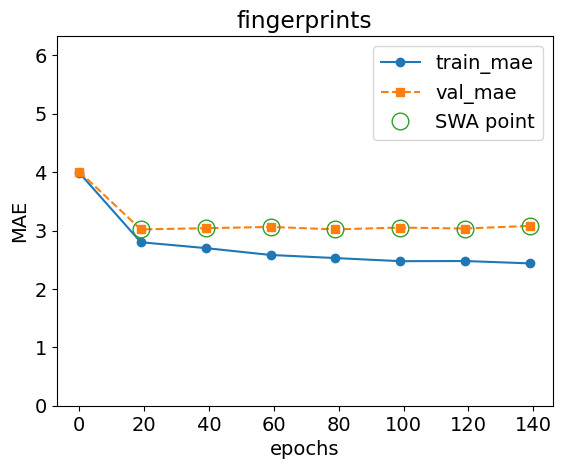

Discarded: 3/3weight updates, early-stopping now
Saving network (fingerprints) to models/trained_models/fingerprints.pth


In [7]:
fingerprints = list(features_df.columns[3:2052])

cb_fingerprints = CrabNet(mat_prop="pce",
                          model_name='fingerprints',
                          elem_prop='mat2vec', 
                          learningcurve=False, 
                          extend_features=fingerprints)
cb_fingerprints.fit(fp_train_df, fp_val_df)

Generating EDM: 100%|██████████| 545/545 [00:00<00:00, 135308.14formulae/s]


loading data with up to 9 elements in the formula


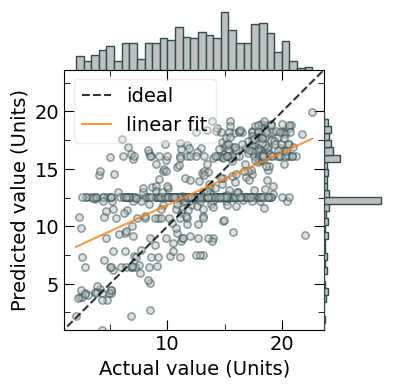

R2 score: 0.396043492803274
MSE: 14.36749377767106
MAE: 2.953780795469787


In [18]:
# Predictions
y_pred, y_pred_sigma = cb_fingerprints.predict(fp_test_df, return_uncertainty=True)

# plot
act_pred(fp_test_df['target'], y_pred)

# statistics
r2 = r2_score(fp_test_df['target'], y_pred)
print(f'R2 score: {r2}')
mse = mean_squared_error(fp_test_df['target'], y_pred)
print(f'MSE: {mse}')
mae = mean_absolute_error(fp_test_df['target'], y_pred)
print(f'MAE: {mae}')

In [14]:
pred_df_zeros

,formula,bandgap,device_stack,target,ETL_FP_0,ETL_FP_1,ETL_FP_2,ETL_FP_3,ETL_FP_4,ETL_FP_5,...,HTL_FP_1015,HTL_FP_1016,HTL_FP_1017,HTL_FP_1018,HTL_FP_1019,HTL_FP_1020,HTL_FP_1021,HTL_FP_1022,HTL_FP_1023,count
3719,CH6I3NPb,1.59,"['SLG', 'ITO', 'Graphene oxide', 'Perovskite',...",0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2386,C100H521I300N179Pb100,0.00,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'ZrO2-mp',...",0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3236,C5H30I15N7Pb5,0.00,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1540,Br51C95Cs5H491I249N174Pb100,0.00,"['SLG', 'FTO', 'SnO2-np', 'OTES:APTES-SAM', 'P...",0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1217,Br48C95Cs5H491I252N174Pb100,1.63,"['SLG', 'ITO', 'NiO-c', 'Perovskite', 'C60', '...",0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,CH6I3NPb,1.50,"['SLG', 'FTO', 'CeOx', 'Perovskite', 'Spiro-Me...",0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
5191,CH6I3NPb,1.60,"['SLG', 'FTO', 'TiO2-c', 'ITIC', 'Perovskite',...",0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
5226,CH6I3NPb,1.54,"['SLG', 'ITO', 'ZnO-c', 'Perovskite', 'Spiro-M...",0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
5390,CsI3Pb,0.00,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
